# TRY CLIP MODEL

First test of CLIP model with Tensorflow (from HuggingFace) and design of a test Lambda function for extracting text features 

In [1]:
import tensorflow as tf
import transformers
import os
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from PIL import Image

2023-03-20 15:19:41.919419: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 15:19:41.919471: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-20 15:19:45.991536: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-20 15:19:45.991995: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-20 15:19:45.992018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

### <b>CONSTANTS</b>

In [137]:
DATA_PATH = 'data'
IMAGES_PATH = os.path.join(DATA_PATH, 'unsplash-research-dataset-lite-latest')
IMAGES_OUTPUT = os.path.join(DATA_PATH, 'unsplash_output_images')
ASSETS_PATH = os.path.join(DATA_PATH, 'assets')
RESIZE = (256,256)

### Test text features

In [3]:
from transformers import CLIPTokenizer, TFCLIPModel

model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

inputs = tokenizer(["a photo of a hound", "a photo of a dog"], padding=True, return_tensors="tf")

text_features = model.get_text_features(**inputs)

2023-03-20 15:20:04.443645: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-20 15:20:04.444267: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-20 15:20:04.444312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (robert-VirtualBox): /proc/driver/nvidia/version does not exist
All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


In [4]:
text_features

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01764771, -0.06101748, -0.48657253, ..., -0.52767116,
        -0.40301576,  0.09337825],
       [ 0.09318563,  0.2764239 , -0.4137126 , ..., -0.5851508 ,
        -0.25898555,  0.11934153]], dtype=float32)>

In [5]:
text_features[1].shape

TensorShape([512])

In [6]:
inputs = tokenizer(["two people", "three animals"], padding=True, return_tensors="tf")

text_features = model.get_text_features(**inputs)
text_features

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[ 0.17750095,  0.19445264, -0.28562412, ..., -0.17539619,
        -0.2911576 , -0.26320773],
       [ 0.01065241, -0.13888812, -0.4637655 , ..., -0.31221306,
        -0.29851586, -0.19083512]], dtype=float32)>

In [22]:
model = TFCLIPModel.from_pretrained("/home/robert/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/snapshots/e6a30b603a447e251fdaca1c3056b2a16cdfebeb/")

tokenizer = CLIPTokenizer.from_pretrained("/home/robert/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/snapshots/e6a30b603a447e251fdaca1c3056b2a16cdfebeb/")

inputs = tokenizer(["a photo of a hound", "a photo of a dog"], padding=True, return_tensors="tf")

text_features = model.get_text_features(**inputs)

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at /home/robert/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/snapshots/e6a30b603a447e251fdaca1c3056b2a16cdfebeb/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


In [23]:
m = tf.keras.metrics.CosineSimilarity()
m.update_state(text_features[0], text_features[1])
m.result().numpy()

0.9110415

### Test image features

In [8]:
df_images = pd.read_csv(os.path.join(IMAGES_PATH, 'photos.tsv000'), delimiter='\t')
df_images.head()

,photo_id,photo_url,photo_image_url,photo_submitted_at,photo_featured,photo_width,photo_height,photo_aspect_ratio,photo_description,photographer_username,...,photo_location_country,photo_location_city,stats_views,stats_downloads,ai_description,ai_primary_landmark_name,ai_primary_landmark_latitude,ai_primary_landmark_longitude,ai_primary_landmark_confidence,blur_hash
0,XMyPniM9LF0,https://unsplash.com/photos/XMyPniM9LF0,https://images.unsplash.com/uploads/1411949294...,2014-09-29 00:08:38.594364,t,4272,2848,1.50,Woman exploring a forest,michellespencer77,...,NaN,NaN,2375421,6967,woman walking in the middle of forest,NaN,NaN,NaN,NaN,L56bVcRRIWMh.gVunlS4SMbsRRxr
1,rDLBArZUl1c,https://unsplash.com/photos/rDLBArZUl1c,https://images.unsplash.com/photo-141633941111...,2014-11-18 19:36:57.08945,t,3000,4000,0.75,Succulents in a terrarium,ugmonk,...,NaN,NaN,13784815,82141,succulent plants in clear glass terrarium,NaN,NaN,NaN,NaN,LvI$4txu%2s:_4t6WUj]xat7RPoe
2,cNDGZ2sQ3Bo,https://unsplash.com/photos/cNDGZ2sQ3Bo,https://images.unsplash.com/photo-142014251503...,2015-01-01 20:02:02.097036,t,2564,1710,1.50,Rural winter mountainside,johnprice,...,NaN,NaN,1302461,3428,rocky mountain under gray sky at daytime,NaN,NaN,NaN,NaN,LhMj%NxvM{t7_4t7aeoM%2M{ozj[
3,iuZ_D1eoq9k,https://unsplash.com/photos/iuZ_D1eoq9k,https://images.unsplash.com/photo-141487280988...,2014-11-01 20:15:13.410073,t,2912,4368,0.67,Poppy seeds and flowers,krisatomic,...,NaN,NaN,2890238,33704,red common poppy flower selective focus phography,NaN,NaN,NaN,NaN,LSC7DirZAsX7}Br@GEWWmnoLWCnj
4,BeD3vjQ8SI0,https://unsplash.com/photos/BeD3vjQ8SI0,https://images.unsplash.com/photo-141700759404...,2014-11-26 13:13:50.134383,t,4896,3264,1.50,Silhouette near dark trees,jonaseriksson,...,NaN,NaN,8704860,49662,trees during night time,NaN,NaN,NaN,NaN,L25|_:V@0hxtI=W;odae0ht6=^NG


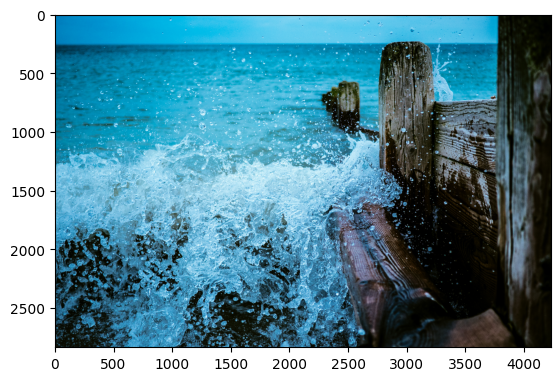

In [10]:
idx = np.random.randint(len(df_images))
image_data = requests.get(df_images.loc[idx, 'photo_image_url'], stream=True).content
image_data = tf.io.decode_image(image_data).numpy()
plt.imshow(image_data)

In [11]:
response = requests.get(df_images.loc[idx, 'photo_image_url'], stream=True)
response.headers['Content-Type'].split('/')[-1]

'octet-stream'

#### Download images

In [302]:
from io import BytesIO

if not os.path.exists(IMAGES_OUTPUT):
    os.mkdir(IMAGES_OUTPUT)

NUM_IMAGES = 200
idx_list = np.random.randint(len(df_images), size=NUM_IMAGES)

for idx in idx_list:
    image = df_images.iloc[idx]
    response = requests.get(image['photo_image_url'], stream=True)
    
    if response.status_code == 200:
        extension = response.headers['Content-Type'].split('/')[-1]
        extension = 'jpeg' if extension == 'octet-stream' else extension
        image_path = os.path.join(IMAGES_OUTPUT, image['photo_id'] + '.' + extension)
        
        if not os.path.exists(image_path):
            img = Image.open(BytesIO(response.content)).resize(RESIZE)
            img.save(image_path)
        else:
            print(f"Image with ID {image['photo_id']}[{idx}] already exists in directory")
    else:
        print(f"Image with ID {image['photo_id']}[{idx}] failed to download")

Image with ID bOfUo9UmR6s[22216] already exists in directory


In [ ]:
from multiprocessing import Pool

def download_images(image):
    url, image_id = image[0], image[1]
    response = requests.get(url, stream=True)
    
    if response.status_code == 200:
        extension = response.headers['Content-Type'].split('/')[-1]
        extension = 'jpeg' if extension == 'octet-stream' else extension
        image_path = os.path.join(IMAGES_OUTPUT, image_id + '.' + extension)
        
        if not os.path.exists(image_path):
            img = Image.open(BytesIO(response.content)).resize(RESIZE)
            img.save(image_path)
        else:
            print(f"Image with ID {image_id} already exists in directory")
    else:
        print(f"Image with ID {image_id} failed to download")

NUM_IMAGES = 500     
images = df_images.loc[:NUM_IMAGES, ['photo_image_url', 'photo_id']].to_numpy().tolist()

pool = Pool()
pool.map(download_images, images)

Process ForkPoolWorker-3:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [314]:
image_paths = pd.DataFrame(os.listdir(IMAGES_OUTPUT), columns=['filename'])
image_paths

,filename
0,sDJpH62NVnc.jpeg
1,YeWfFANhSUo.jpeg
2,QsEO-fynmos.jpeg
3,m0XjkoEtvG8.jpeg
4,rzOxBlhkziE.jpeg
...,...
693,tyX01W6KCyI.jpeg
694,f9uAn6snTs8.jpeg
695,GIsFHopvbPA.jpeg
696,QqRuDeIXb5I.jpeg


In [13]:
from transformers import CLIPProcessor, TFCLIPModel

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
from transformers import CLIPProcessor, TFCLIPModel

model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

idx = np.random.randint(len(df_images))
random_image = df_images.iloc[idx]
image = Image.open(requests.get(random_image['photo_image_url'], stream=True).raw)

inputs = processor(images=image, return_tensors="tf")

image_features = model.get_image_features(**inputs)
image_features

In [10]:
image_features.shape

TensorShape([1, 512])

In [11]:
text_features.shape

TensorShape([2, 512])

### Extract image embeddings for the dataset

In [12]:
from transformers import CLIPProcessor, TFCLIPModel

model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


In [ ]:
from tqdm import tqdm

images_paths = [os.path.join(root, file) for root, dirs, files in os.walk(IMAGES_OUTPUT) for file in files]
image_embeddings = []

for path in tqdm(images_paths):
    image = Image.open(path).resize(RESIZE)
    
    inputs = processor(images=image, return_tensors="tf")
    image_features = model.get_image_features(**inputs)
    image_embeddings.append(image_features / np.linalg.norm(image_features, ord=2))
    del image

In [320]:
# use of multiprocessing for speedup

from multiprocessing import Pool
from tqdm import tqdm

images_paths = [os.path.join(root, file) for root, dirs, files in os.walk(IMAGES_OUTPUT) for file in files]

def extract_image_embeddings(path):
    image = Image.open(path).resize(RESIZE)
    
    inputs = processor(images=image, return_tensors="tf")
    image_features = model.get_image_features(**inputs)
    del image
    
    return path, image_features / np.linalg.norm(image_features, ord=2)
    
with Pool(5) as p:
    image_embeddings = list(tqdm(p.imap(extract_image_embeddings, images_paths), total=len(images_paths)))

100%|█████████████████████████████████████████████████████| 698/698 [12:43<00:00,  1.09s/it]


In [322]:
image_paths, image_embeddings = zip(*image_embeddings)
image_paths = np.array(image_paths)
image_embeddings = list(image_embeddings)

In [326]:
np.save(os.path.join(ASSETS_PATH, 'images_filenames.npy'), np.array(images_paths), allow_pickle=True)

In [327]:
np.save(os.path.join(ASSETS_PATH, 'image_CLIP_embeddings.npy'), tf.convert_to_tensor(image_embeddings).numpy().squeeze(), allow_pickle=True)

### Fetch images based on user text input

In [328]:
embeddings = np.load(os.path.join(ASSETS_PATH, 'image_CLIP_embeddings.npy'))
images_paths = np.load(os.path.join(ASSETS_PATH, 'images_filenames.npy'))
embeddings.shape

(698, 512)

In [203]:
model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


#### <b>Search in "sequential" mode</b>
Euclidean distance or cosine similarity for each vector in the embeddings matrix

In [387]:
user_input = input("Search images:").lower()

inputs = tokenizer(user_input, padding=True, return_tensors="tf")

text_features = model.get_text_features(**inputs).numpy().squeeze()

Search images: food


In [388]:
dists = []
cosines = []
for i, emb in enumerate(embeddings):
    cos_sim = np.dot(text_features, emb) / np.linalg.norm(text_features)
    l2_dist = np.linalg.norm((text_features / np.linalg.norm(text_features)) - emb, ord=2)
    dists.append(l2_dist)
    cosines.append(cos_sim)
    #print(f'Index {i}:', l2_dist)

dists = np.array(dists)
print('Most similar index (DISTANCE):', dists.argmin())
print('Top 10 similar indexes (DISTANCE):', dists.argsort()[:10])
print()

cosines = np.array(cosines)
print('Most similar index (COSINE):', cosines.argmax())
print('Top 10 similar indexes (COSINE):', cosines.argsort()[::-1][:10])

Most similar index (DISTANCE): 365
Top 10 similar indexes (DISTANCE): [365 671 376 625 250 282 368 176 197 321]

Most similar index (COSINE): 365
Top 10 similar indexes (COSINE): [365 671 376 625 250 282 368 176 197 321]


In [389]:
cosines[cosines.argsort()[::-1][:10]]

array([0.24691004, 0.24464057, 0.24108936, 0.23761083, 0.23651761,
       0.2358093 , 0.23396923, 0.23243931, 0.23222214, 0.23150098],
      dtype=float32)

In [390]:
def show_images(images, num_images=10, columns=5):
    fig = plt.figure(figsize=(20, 20))
    for i in range(num_images):
        fig.add_subplot(int(len(images) / columns + 1), columns, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

In [391]:
NUM_IMAGES = 10
RESHAPE = (256,256)

most_similar = dists.argsort()[:NUM_IMAGES] # cosines.argsort()[::-1][:NUM_IMAGES] #
loaded_images = []

for idx in most_similar:
    path = images_paths[idx]
    image = np.asarray(Image.open(path).resize(RESHAPE))
    loaded_images.append(image)
    del image
    
loaded_images = np.array(loaded_images)
loaded_images.shape

(10, 256, 256, 3)

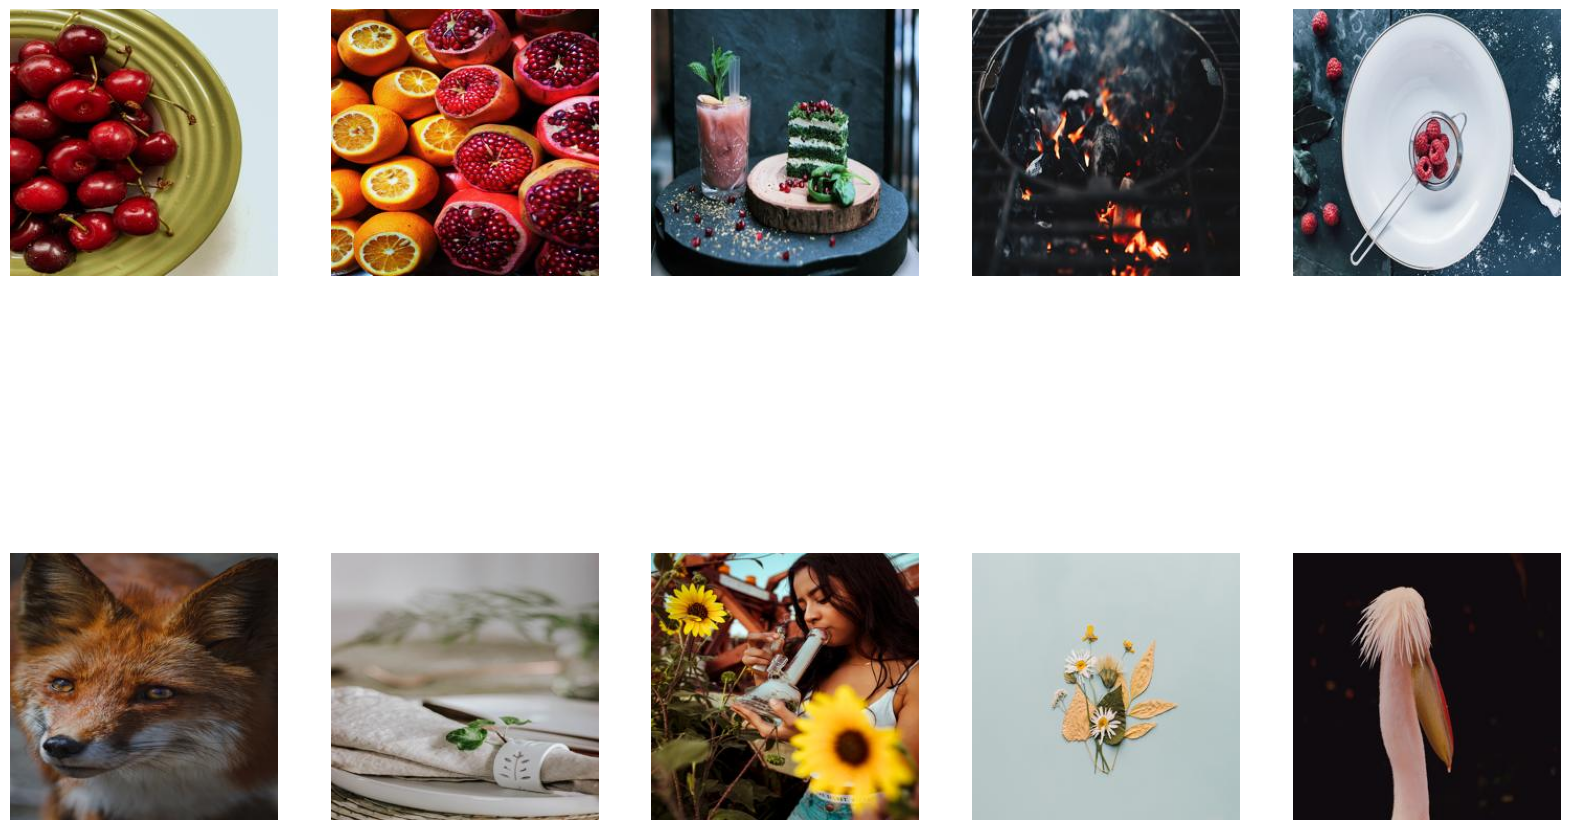

In [392]:
show_images(loaded_images, num_images=NUM_IMAGES)

#### <b>Using sklearn's KNN</b>

[(478, 9.76640778112739), (267, 9.76711004333589), (541, 9.767538874958632), (3, 9.768177400819804), (532, 9.769396537330916), (157, 9.770010343485641), (483, 9.770972754507913), (236, 9.775710417159269), (364, 9.775935962873085), (177, 9.777184174561752)]


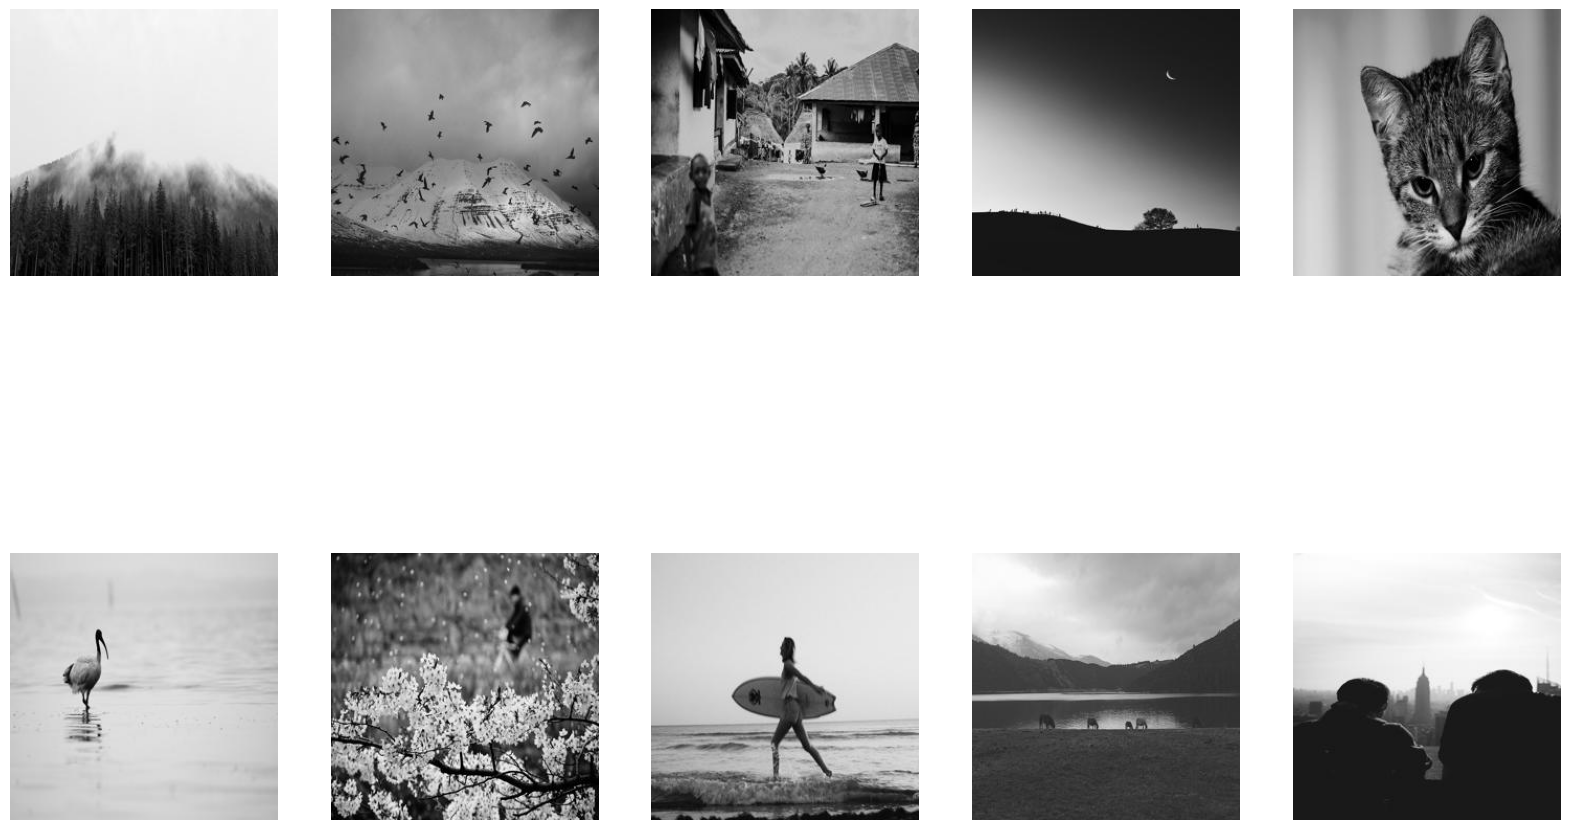

In [374]:
from sklearn.neighbors import KNeighborsClassifier

NEIGHBORS = 10
knn = KNeighborsClassifier(n_neighbors=NEIGHBORS).fit(embeddings, np.zeros(len(embeddings)))

neigh_dist, neigh_ind = knn.kneighbors([text_features], n_neighbors=NEIGHBORS)

print(list(zip(neigh_ind.squeeze(), neigh_dist.squeeze())))

loaded_images = []

for idx in neigh_ind.squeeze():
    path = images_paths[idx]
    image = np.asarray(Image.open(path).resize(RESHAPE))
    loaded_images.append(image)
    del image
    
loaded_images = np.array(loaded_images)
show_images(loaded_images, num_images=NUM_IMAGES)

### Lambda function

In [ ]:
import json

def lambda_handler(event, context):
    # TODO implement
    return {
        'statusCode': 200,
        'body': json.dumps('Hello from Lambda!')
    }
